# ---------------------------------------------------------------------------------------------------------------
#
#         R Script to Download and Graph USGS Streamflow data from the Upper Columbia
#            Author: Ryan Niemeyer, Watershed Program Manager at the Upper Columbia Salmon Recovery Board
#            Date: Fall 2020
#
# ---------------------------------------------------------------------------------------------------------------

In [274]:
# ------------------ Year to Plot ------------------
year_to_plot = 2019
# --------------- Pathway to Output Figure --------------
path_output = 'Y:/Ryan/Misc/Annual_Report/2019/usgs_streamflow_graph_2.pdf'

In [275]:
library(data.table)
#library(EGRET)

# ---------------------------------------------------------------------------------------------------
#         Establish Which Sites
# ---------------------------------------------------------------------------------------------------


In [297]:
USGS_site = 'P:/GIS/Water/rivers/USGS_stream_gauge_sites.csv'
USGS_sites = read.csv(USGS_site, header=T)
USGS_sites$area_catchment_sq_miles = as.numeric(as.character(USGS_sites$area_catchment_sq_miles))

In [279]:
head(USGS_sites)

,USGS_site_no,Site_name,City,subbasin,area_catchment_sq_miles
,<int>,<chr>,<chr>,<chr>,<dbl>
1,12447200,"OKANOGAN RIVER AT MALOTT, WA",Malott,Okanogan,8080
2,12446995,"SALMON CREEK ABOVE DIVERSION NEAR OKANOGAN, WA",Okanogan,Okanogan,148
3,12449950,"METHOW RIVER NEAR PATEROS, WA",Pateros,Methow,1772
4,12448998,"TWISP RIVER NEAR TWISP, WA",Twisp,Methow,245
5,12452990,"ENTIAT RIVER NEAR ENTIAT, WA",Entiat,Entiat,419
6,12452890,"MAD RIVER AT ARDENVOIR, WA",Ardenvoir,Entiat,92


# ----------------------------------------------------------------------------------
#         Functions
# ----------------------------------------------------------------------------------

In [46]:

# ---------------------------------------------------------------------------------------------------
#          Download USGS data 
# ---------------------------------------------------------------------------------------------------

FXN_download_streamflow_output_daily_flow = function(site_x, area_catchment_sq_miles, start_date_x, end_date_x, use_provisional){
  
  # ------------ set up conversions ----------
  ft3_to_mm3 = 2.832e+7
  sec_to_day = 86400
  mi2_to_ft2 = 27878400
  mi2_to_mm2 = 2589988110000
  
  # --------- re-calculate area -------
  area_catchment_sq_ft = area_catchment_sq_miles * mi2_to_ft2  # convert square miles to square feet
  area_catchment_sq_mm = area_catchment_sq_miles * mi2_to_mm2  # convert square miles to square mm
  
  # ---------- Update path ----------
  path_origx = 'https://waterdata.usgs.gov/nwis/dv?cb_00010=on&cb_00060=on&cb_80154=on&cb_80155=on&format=rdb&site_no=SITE_NUMBER&referred_module=sw&period=&begin_date=START_DATE&end_date=END_DATE'
  path_updated_x = gsub('SITE_NUMBER', site_x, path_origx)
  path_updated_x = gsub('START_DATE', start_date_x, path_updated_x)
  path_updated_x = gsub('END_DATE', end_date_x, path_updated_x)
  
  # ------------ Download Data ----------
  datax = fread(path_updated_x)
  datax = as.data.frame(datax)
  datax = datax[c(3:nrow(datax)),]  # remove the first two rows that aren't data
  
  # ----- use provisional or not --------
  if(use_provisional == TRUE){
    datax2 = datax[,c(3:4)]
  }else{
    x = which(datax[,5]=='A')  # A is that means it's been processed, P means it is provisonal
    datax2 = datax[x,c(3:4)]
  }
  
  # ----- assign names and calculate with updated units -----------
  colnames(datax2) = c('datetime','discharge_ft3_sec') # set column mames
  datax2$discharge_ft3_sec = as.numeric(as.character(datax2$discharge_ft3_sec))   # set as numeric
  datax2$discharge_mm_day =  datax2$discharge_ft3_sec*sec_to_day*ft3_to_mm3/area_catchment_sq_mm    # convert to mm per day flow

  # ------- set date time ------
  datax2$datetime2 = as.POSIXct(datax2$datetime, format = "%Y-%m-%d", tz='UTC')
  datax2$wtr_yr = wtr_yr(datax2$datetime2, start_month = 10)
  
  # ---------- output data --------------
  return(datax2)
}



In [47]:

# ---------------- water year function ----------
wtr_yr <- function(dates, start_month=10) {
  # Convert dates into POSIXlt
  dates.posix = as.POSIXlt(dates)
  # Year offset
  offset = ifelse(dates.posix$mon >= start_month - 1, 1, 0)
  # Water year
  adj.year = dates.posix$year + 1900 + offset
  # Return the water year
  adj.year
}

In [261]:

# -------------------------- FUNCTION to calculate median flow ------------------------

median_flow_function = function(metric_vector, date_vector, year_for_days){
    
    # --------------------- get day of year ---------------
    day_of_year =  format(date_vector, format="%j")
    
    # ----------------------- get median for that day of year -------------
    data_x = as.data.frame(cbind(day_of_year, metric_vector))
    data_x$metric_vector = as.numeric(data_x$metric_vector)
    median_x = aggregate(data_x$metric_vector, list(data_x$day_of_year), FUN=median, na.rm=TRUE, na.action = NULL)
    colnames(median_x) = c('day_of_year', 'metric')
    
    # -------------------- remove day 366 (from leap year) ------------
    median_x = median_x[1:365,]
    
    # ------------- add day of hydrologic year --------------
    median_x$day_of_hydro_year = median_x$day_of_year
    
    # ---------- days after Oct. 1 -------------
    days_previous_calendar_year = which(median_x$day_of_year > 274)
    median_x$day_of_hydro_year[days_previous_calendar_year] = paste(median_x$day_of_hydro_year[days_previous_calendar_year],
                                                                    year_for_days - 1, sep="-")
    
    # ---------- days before Oct. 1 -------------
    days_during_calendar_year = which(median_x$day_of_year <= 274)
    median_x$day_of_hydro_year[days_during_calendar_year] = paste(median_x$day_of_hydro_year[days_during_calendar_year],
                                                                    year_for_days, sep="-")
    # --------------- get date time -------------
    median_x$day_of_hydro_year =  as.POSIXct(median_x$day_of_hydro_year, format="%j-%Y",tz="America/Los_Angeles")
    
    # ----------------- return the data ------------------
    return(median_x)
    
}


In [60]:
movingAverage <- function(x, n=1, centered=FALSE) {
    
    if (centered) {
        before <- floor  ((n-1)/2)
        after  <- ceiling((n-1)/2)
    } else {
        before <- n-1
        after  <- 0
    }

    # Track the sum and count of number of non-NA items
    s     <- rep(0, length(x))
    count <- rep(0, length(x))
    
    # Add the centered data 
    new <- x
    # Add to count list wherever there isn't a 
    count <- count + !is.na(new)
    # Now replace NA_s with 0_s and add to total
    new[is.na(new)] <- 0
    s <- s + new
    
    # Add the data from before
    i <- 1
    while (i <= before) {
        # This is the vector with offset values to add
        new   <- c(rep(NA, i), x[1:(length(x)-i)])

        count <- count + !is.na(new)
        new[is.na(new)] <- 0
        s <- s + new
        
        i <- i+1
    }

    # Add the data from after
    i <- 1
    while (i <= after) {
        # This is the vector with offset values to add
        new   <- c(x[(i+1):length(x)], rep(NA, i))
       
        count <- count + !is.na(new)
        new[is.na(new)] <- 0
        s <- s + new
        
        i <- i+1
    }
    
    # return sum divided by count
    s/count
}


In [203]:
# ------------ JUST for testing (need to read in data below) ---------
run_test = TRUE

if(run_test){
    i = 1
    site_x = USGS_sites$USGS_site_no[i]

    # ------------------------ generate the median snotel -------------------
    streamflow_data_x = as.numeric(as.character(all_USGS_data[[site_x]]$'discharge_ft3_sec' ))
    date_vector = all_USGS_data[[as.numeric(USGS_sites$USGS_site_no[i])]]$'datetime'
    streamflow_basin_area_x = as.numeric(as.character(all_USGS_data[[site_x]]$'discharge_mm_day' ))
    date_vector_datetime2 = as.POSIXct(date_vector, format="%Y-%m-%d")
    date_data_calendar_yr = format(date_vector_datetime2, '%Y')
}


In [250]:

# ------------------ FUNCTION to calculate flow statistics ----------------------


USGS_flow_statistics = function(streamflow_data_x, streamflow_basin_area_x, date_vector, year_to_plot){
    
    # ----- convert mm to inches -----
    mm_to_inches = 0.03937008
    
    # -------- convert to date time --------
    date_vector_datetime2 = as.POSIXct(date_vector, format="%Y-%m-%d")
    
    # ----------- water year -----------
    date_data_wtr_yr = wtr_yr(date_vector_datetime2)
    
    # -------- calendar year -------
    date_data_calendar_yr = format(date_vector_datetime2, '%Y')
       
    # ---------------------------------------------------------------------------------
    #        Annual peakflow statistics          
    # ---------------------------------------------------------------------------------

    # ----------------- calculate annual peak 7-day average flow -----------------
    seven_day_average  = movingAverage(streamflow_data_x, n=7)                   # calculate 7-day average flow (ft3 per sec)
    annual_max = aggregate(seven_day_average, list(date_data_wtr_yr), max, na.rm=TRUE)       # get max 7-day average flow
    annual_max_year = round( annual_max[which(annual_max[ ,1] == year_to_plot),2], 2)   # peak flow for the "year to plot"
    mean_annual_max = mean(annual_max[,2], na.rm=T)                   # mean peak flow across all years
    prcnt_annual_max_year = round((annual_max_year/mean_annual_max) * 100, 2)  # percent difference in year to plot from mean year
    delta_annual_max_year = round((annual_max_year - mean_annual_max), 2)    # the absolute difference between year to plot and average
    
    # -------------- day of annual peakflow ---------------
    day_of_annual_max = c()
    unique_years = unique(date_data_wtr_yr)
    for(i in 1:length(unique_years)){

        # ----------------- get peak flow for this year -----------------
        year_x = unique_years[i]
        x = which(date_data_wtr_yr == unique_years[i])
        # ----- get data for that year -----
        annual_flow = seven_day_average[x]
        # -------------- calculate calendar day of peak -----------
        day_of_peak = which(annual_flow == annual_max[i,2])
        day_of_peak = day_of_peak[1] - 92 # get calendary year day, from water year day
        # ------------------ calculate month and day ---------
        day_of_peak_2 = paste(day_of_peak,  year_x, sep="-")
        day_of_peak_2 = as.Date(day_of_peak_2, format='%j-%Y')
        day_of_peak_2 = format(day_of_peak_2, "%d-%b") # output as day and month
        # ------------- output data --------
        output_row = c(unique_years[i], day_of_peak[1], day_of_peak_2[1])
        day_of_annual_max = rbind(day_of_annual_max, output_row)
    }
    
    # ------------------------- calculate for this year -----------
    peakflow_day = as.numeric(day_of_annual_max[which(day_of_annual_max[ ,1] == year_to_plot),2])
    mean_peakflow_ALL = round(  ( mean(as.numeric(day_of_annual_max[,2]), na.rm=T) ), 2)
    delta_peakflow_day = round(peakflow_day - mean_peakflow_ALL, 2) # days difference from average
    
    # ---------------------------------------------------------------------------------
    #        Annual lowflow statistics          
    # ---------------------------------------------------------------------------------

    # ----------------- calculate annual peak snow statistics -----------------
    annual_min = aggregate(seven_day_average, list(date_data_wtr_yr), min, na.rm=TRUE)   # get annual 7-day min each year (ft3 per sec)
    annual_min_year = round( annual_min[which(annual_min[ ,1] == year_to_plot),2], 2)   # annual 7-day min for the year to plot
    mean_annual_min = mean(annual_min[,2], na.rm=T)      # mean annual min 7-day flow across all years
    prcnt_annual_min_year = round((annual_min_year/mean_annual_min) * 100, 2)    # percent difference in year to plot from mean year
    delta_annual_min_year = round((annual_min_year - mean_annual_min), 2)    # the absolute difference between year to plot and average
    
    # -------------- day of annual low flow---------------
    day_of_annual_min = c()
    unique_years = unique(date_data_wtr_yr)
    for(i in 1:length(unique_years)){

        # ----------------- get low flow this year -----------------
        year_x = unique_years[i]
        x = which(date_data_wtr_yr == unique_years[i])
        # ----- get data for that year -----
        annual_flow = seven_day_average[x]
        # -------------- calculate calendar day of low flow -----------
        day_of_low = which(annual_flow == annual_min[i,2])
        day_of_low = day_of_low[1] - 92 # get calendary year day, from water year day
        # ------------------ calculate month and day ---------
        day_of_low_2 = paste(day_of_low,  year_x, sep="-")
        day_of_low_2 = as.Date(day_of_low_2, format='%j-%Y')
        day_of_low_2 = format(day_of_low_2, "%d-%b") # output as day and month
        # ------------- output data --------
        output_row = c(unique_years[i], day_of_low[1], day_of_low_2[1])
        day_of_annual_min = rbind(day_of_annual_min, output_row)
    }
    
    # ------------------------- calculate for this year -----------
    lowflow_day = as.numeric(day_of_annual_min[which(day_of_annual_min[ ,1] == year_to_plot),2])
    mean_lowflow_ALL = round(  ( mean(as.numeric(day_of_annual_min[,2]), na.rm=T) ), 2)
    delta_lowflow_day = round(lowflow_day - mean_lowflow_ALL, 2) # days difference from average
    
    # ---------------------------------------------------------------------------------
    #           Calculate center of mass of flow
    # ---------------------------------------------------------------------------------

    # ----------------- calculate annual melt out day statistics -----------------
    date_data_wtr_yr = wtr_yr(date_vector)
    unique_years = unique(date_data_wtr_yr)
    flow_center_of_mass = c()
    for(i in 1:length(unique_years)){

        # ----------------- get snow this year -----------------
        x = which(date_data_wtr_yr == unique_years[i])
        annual_streamflow = streamflow_data_x[x]
        annual_dates = date_vector[x]

        # ------------- cumulative streamflow -----------
        annual_cumulative_streamflow = cumsum(annual_streamflow)

        # ------------- calculate melt out year ----------------
        annual_cumulative_streamflow_CENTER = max(annual_cumulative_streamflow)/2
        location_center_of_mass = which.min(abs(annual_cumulative_streamflow - annual_cumulative_streamflow_CENTER))
        date_center_of_mass = annual_dates[location_center_of_mass]
        flow_center_of_mass = rbind(flow_center_of_mass, date_center_of_mass)
    }

    # ------------------------- calculate for this year -----------
    flow_center_of_mass = as.data.frame(flow_center_of_mass)   # convert to data frame
    flow_center_of_mass$datetime2 = as.POSIXct(flow_center_of_mass[,1], format="%Y-%m-%d")   # date formatting
    flow_center_of_mass$year = format(flow_center_of_mass$datetime2, '%Y')         # generate year column
    flow_center_of_mass$day_of_year = format(flow_center_of_mass$datetime2, '%j')  # generate calendar day column
    flow_center_day = as.numeric(flow_center_of_mass$day_of_year[which(flow_center_of_mass$year == year_to_plot)])[1]   # flow center day for the year of interest
    flow_center_day_ALL = round( (mean(as.numeric(flow_center_of_mass$day_of_year), na.rm=T)),  2)   # mean flow center day for all years
    delta_flow_center_day = round(flow_center_day - flow_center_day_ALL, 2)     # days difference from average

    # ---------------------------------------------------------------------------------
    #           Calculate total annual discharge
    # ---------------------------------------------------------------------------------

    annual_total = aggregate(streamflow_basin_area_x, list(date_data_wtr_yr), sum, na.rm=TRUE) # total flwo for all years (in mm)
    annual_total_year = round( annual_total[which(annual_total[ ,1] == year_to_plot),2], 2)   # total annual flow in year of interest
    mean_annual_total = mean(annual_total[,2], na.rm=T)    # mean of total annual flow
    prcnt_annual_total_year = round((annual_total_year/mean_annual_total) * 100, 2)   #  percent departure from average/normal
    delta_annual_total_year = round((annual_total_year - mean_annual_total), 2)   # absolute departure from normal/difference
    
    # ----- calculate to inches ------
    annual_total_year_inches = annual_total_year * mm_to_inches  
    mean_annual_total_inches = mean_annual_total * mm_to_inches
    delta_annual_total_year_inches = delta_annual_total_year * mm_to_inches
    
    # ---------------------------------------------------------------------------------
    #           Calculate monthly statistics (esp Aug and Sept)
    # ---------------------------------------------------------------------------------

    monthly_data = aggregate(streamflow_data_x, list(format(date_vector_datetime2, '%m')), mean, na.rm=TRUE)
    unique_years = unique(date_data_calendar_yr)
    # -------------- day of annual low flow---------------
    monthly_flow_df = c()
    for(i in 1:length(unique_years)){

        # ----------------- get data for this year -----------------
        year_x = unique_years[i]
        x = which(date_data_calendar_yr == unique_years[i])
        annual_flow = streamflow_data_x[x]

        # -------------- calculate monthly means -----------
        monthly_flow_x_i = aggregate(annual_flow, list(format(date_vector_datetime2[x], '%m')), mean, na.rm=TRUE)
        monthly_flow_x = round(monthly_flow_x_i[,2], 1)

        # ------------- output data --------
        if(nrow(monthly_flow_x_i)<12){next}
        output_row = c(unique_years[i], monthly_flow_x)
        monthly_flow_df = rbind(monthly_flow_df, output_row)
    }
    
    # ------------------------- calculate means_for_each_month-----------
    monthly_flow_df = as.data.frame(monthly_flow_df)
    i = seq(1:13)
    monthly_flow_df[ , i] = apply(monthly_flow_df[ , i], 2,function(x) as.numeric(as.character(x))) # convert all to numeric
    monthly_flow_df_MEANS = colMeans(monthly_flow_df)  # calculate mmean onthly flow

    # ---------- get this month -----------
    monthly_flow_year_to_plot = monthly_flow_df[which(monthly_flow_df[,1] == year_to_plot),2:13] # monthly flows for year of interest
    delta_monthly_flow_year = round(monthly_flow_year_to_plot - monthly_flow_df_MEANS[2:13] , 2) # days difference from average
    delta_monthly_flow_year_PRCNT = round((monthly_flow_year_to_plot/monthly_flow_df_MEANS[2:13])*100, 2)
                                  
    # ---------------------------------------------------------------------------------
    #      Output         
    # ---------------------------------------------------------------------------------
    output_x = as.data.frame(c(annual_max_year, mean_annual_max, prcnt_annual_max_year, delta_annual_max_year,  # peak flow statistics
                                 peakflow_day, mean_peakflow_ALL, delta_peakflow_day,                            # peak flow day statistics
                                 annual_min_year, mean_annual_min, prcnt_annual_min_year, delta_annual_min_year,  # low flow statistics
                                 lowflow_day, mean_lowflow_ALL, delta_lowflow_day,                            # low flow day statistics
                                 flow_center_day, flow_center_day_ALL,  delta_flow_center_day,   # flow center day
                                 annual_total_year_inches,  mean_annual_total_inches, prcnt_annual_total_year, delta_annual_total_year_inches ,   # total annual discharge statistics
                                 monthly_flow_year_to_plot, monthly_flow_df_MEANS[2:13],  delta_monthly_flow_year_PRCNT, delta_monthly_flow_year       # monthly flows (EACH vector has 12 for each month)
                ))
                        
    rownames(output_x) = 1 # give the row a simple name
    colnames(output_x) = c('peakflow_7day_avg_year_of_interest_ft3_sec', 'average_7day_avg_peakflow_ft3_sec', 'PRCNT_peakflow_year_of_interest_ft3_sec', 'DELTA_peakflow_year_of_interest_ft3_sec',  # peak flow statistics
                                 'peakflow_day_year_of_interest',  'average_peakflow_day_of_year',  'DELTA_peakflow_day_year_of_interest',                            # peak flow day statistics
                                'lowflow_7day_avg_year_of_interest_ft3_sec', 'average_7day_avg_lowflow_ft3_sec', 'PRCNT_lowflow_year_of_interest_ft3_sec', 'DELTA_lowflow_year_of_interest_ft3_sec',  # low flow statistics
                                 'lowflow_day_year_of_interest',  'average_lowflow_day_of_year',  'DELTA_lowflow_day_year_of_interest',                            # low flow day statistics
                                 'flow_center_of_mass_day_year_of_interest', 'flow_center_of_mass_mean', 'DELTA_flow_center_of_mass_day_year_of_interest',    # flow center day
                                 'annual_total_flow_year_of_interest_inches',  'mean_annual_total_flow_inches', 'PRCNT_annual_total_flow_year_of_interest_inches',   'DELTA_annual_total_flow_year_of_interest_inches',    # total annual discharge statistics
                                'Jan_mean_flow_year_of_interest_ft3_sec', 'Feb_mean_flow_year_of_interest_ft3_sec', 'Mar_mean_flow_year_of_interest_ft3_sec', 'Apr_mean_flow_year_of_interest_ft3_sec', 
                           'May_mean_flow_year_of_interest_ft3_sec', 'Jun_mean_flow_year_of_interest_ft3_sec', 'Jul_mean_flow_year_of_interest_ft3_sec', 'Aug_mean_flow_year_of_interest_ft3_sec', 
                           'Sep_mean_flow_year_of_interest_ft3_sec', 'Oct_mean_flow_year_of_interest_ft3_sec', 'Nov_mean_flow_year_of_interest_ft3_sec', 'Dec_mean_flow_year_of_interest_ft3_sec',
                            'Jan_mean_flow_all_years_ft3_sec', 'Feb_mean_flow_all_years_ft3_sec', 'Mar_mean_flow_all_years_ft3_sec', 'Apr_mean_flow_all_years_ft3_sec', 
                           'May_mean_flow_all_years_ft3_sec', 'Jun_mean_flow_all_years_ft3_sec', 'Jul_mean_flow_all_years_ft3_sec', 'Aug_mean_flow_all_years_ft3_sec', 
                           'Sep_mean_flow_all_years_ft3_sec', 'Oct_mean_flow_all_years_ft3_sec', 'Nov_mean_flow_all_years_ft3_sec', 'Dec_mean_flow_all_years_ft3_sec',
                           'Jan_mean_PRCNT_flow_year_of_interest_ft3_sec', 'Feb_mean_PRCNT_flow_year_of_interest_ft3_sec', 'Mar_mean_PRCNT_flow_year_of_interest_ft3_sec', 'Apr_mean_PRCNT_flow_year_of_interest_ft3_sec', 
                           'May_mean_PRCNT_flow_year_of_interest_ft3_sec', 'Jun_mean_PRCNT_flow_year_of_interest_ft3_sec', 'Jul_mean_PRCNT_flow_year_of_interest_ft3_sec', 'Aug_mean_PRCNT_flow_year_of_interest_ft3_sec', 
                           'Sep_mean_PRCNT_flow_year_of_interest_ft3_sec', 'Oct_mean_PRCNT_flow_year_of_interest_ft3_sec', 'Nov_mean_PRCNT_flow_year_of_interest_ft3_sec', 'Dec_mean_PRCNT_flow_year_of_interest_ft3_sec',
                            'Jan_mean_DELTA_flow_year_of_interest_ft3_sec', 'Feb_mean_DELTA_flow_year_of_interest_ft3_sec', 'Mar_mean_DELTA_flow_year_of_interest_ft3_sec', 'Apr_mean_DELTA_flow_year_of_interest_ft3_sec', 
                           'May_mean_DELTA_flow_year_of_interest_ft3_sec', 'Jun_mean_DELTA_flow_year_of_interest_ft3_sec', 'Jul_mean_DELTA_flow_year_of_interest_ft3_sec', 'Aug_mean_DELTA_flow_year_of_interest_ft3_sec', 
                           'Sep_mean_DELTA_flow_year_of_interest_ft3_sec', 'Oct_mean_DELTA_flow_year_of_interest_ft3_sec', 'Nov_mean_DELTA_flow_year_of_interest_ft3_sec', 'Dec_mean_DELTA_flow_year_of_interest_ft3_sec'

                               # monthly flows (EACH vector has 12 for each month)
                                 )
    
    #print(output_x)
    return(output_x)
    
}
   


# ----------------------------------------------------------------------------------
#         Read in Data
# ----------------------------------------------------------------------------------

In [319]:
all_USGS_data = list() # creates a list

for(i in 1:nrow(USGS_sites)){
    
    # ---------------- read in data and add to master list (all_snotel_data) --------
    site_x = USGS_sites$USGS_site_no[i]
    print('starting download of....')
    print(site_x)
    all_USGS_data[[site_x]] = FXN_download_streamflow_output_daily_flow(USGS_sites$USGS_site_no[i],  USGS_sites$area_catchment_sq_miles[i],
                                                 '1980-10-01', '2020-10-01', TRUE)
    print("         DONE                 ")
    print("       ")
}


[1] "starting download of...."
[1] 12447200


Warning message in fread(path_updated_x):
"Detected 1 column names but the data has 11 columns (i.e. invalid file). Added 10 extra default column names at the end."


[1] "         DONE                 "
[1] "       "
[1] "starting download of...."
[1] 12445900


Warning message in fread(path_updated_x):
"Detected 1 column names but the data has 5 columns (i.e. invalid file). Added 4 extra default column names at the end."


[1] "         DONE                 "
[1] "       "
[1] "starting download of...."
[1] 12449950


Warning message in fread(path_updated_x):
"Detected 1 column names but the data has 5 columns (i.e. invalid file). Added 4 extra default column names at the end."


[1] "         DONE                 "
[1] "       "
[1] "starting download of...."
[1] 12448998


Warning message in fread(path_updated_x):
"Detected 1 column names but the data has 11 columns (i.e. invalid file). Added 10 extra default column names at the end."


[1] "         DONE                 "
[1] "       "
[1] "starting download of...."
[1] 12452990


Warning message in fread(path_updated_x):
"Detected 1 column names but the data has 5 columns (i.e. invalid file). Added 4 extra default column names at the end."


[1] "         DONE                 "
[1] "       "
[1] "starting download of...."
[1] 12452890


Warning message in fread(path_updated_x):
"Detected 1 column names but the data has 5 columns (i.e. invalid file). Added 4 extra default column names at the end."
Warning message in FXN_download_streamflow_output_daily_flow(USGS_sites$USGS_site_no[i], :
"NAs introduced by coercion"


[1] "         DONE                 "
[1] "       "
[1] "starting download of...."
[1] 12462500


Warning message in fread(path_updated_x):
"Detected 1 column names but the data has 11 columns (i.e. invalid file). Added 10 extra default column names at the end."


[1] "         DONE                 "
[1] "       "
[1] "starting download of...."
[1] 12456500


Warning message in fread(path_updated_x):
"Detected 1 column names but the data has 5 columns (i.e. invalid file). Added 4 extra default column names at the end."
Warning message in FXN_download_streamflow_output_daily_flow(USGS_sites$USGS_site_no[i], :
"NAs introduced by coercion"


[1] "         DONE                 "
[1] "       "


# ----------------------------------------------------------------------------------
#             Calculate Statistics
# ----------------------------------------------------------------------------------

In [320]:
# ------------ data frame for statistics ---------
streamflow_statistics_output = c()

for(i in 1:nrow(USGS_sites)){

    # ------------------------------------------------------------
    #          Prepare the Data
    # ------------------------------------------------------------
    print(i)
    print(USGS_sites$USGS_site_no[i])
    site_x = USGS_sites$USGS_site_no[i]
    # ------------------------ generate the streamflow -------------------
    streamflow_m3_sec_data_x = as.numeric(as.character(all_USGS_data[[site_x]]$'discharge_ft3_sec' ))
    streamflow_mm_day_data_x = as.numeric(as.character(all_USGS_data[[site_x]]$'discharge_mm_day' ))
    date_vector = all_USGS_data[[as.numeric(USGS_sites$USGS_site_no[i])]]$'datetime'
    
    # ----------- clip "NAs" at the beginning -------
    x =!is.na(streamflow_m3_sec_data_x)
    x = which(x == TRUE)
    first_not_na = min(x)
    include_x = seq(first_not_na, length(streamflow_m3_sec_data_x))
    streamflow_m3_sec_data_x = streamflow_m3_sec_data_x[include_x]
    streamflow_mm_day_data_x = streamflow_mm_day_data_x[include_x]
    date_vector = date_vector[include_x]
    
    # ---------------- generate output data --------------
    output_data_x = USGS_flow_statistics(streamflow_m3_sec_data_x,  streamflow_mm_day_data_x,  date_vector, year_to_plot)
    sites_df = t(as.data.frame(c(USGS_sites$Site_name[i], USGS_sites$USGS_site_no[i])))
    colnames(sites_df) = c("site_name", "site_number")
    output_data_x = cbind(sites_df, output_data_x)
    rownames(output_data_x) = i
    streamflow_statistics_output = rbind(streamflow_statistics_output, output_data_x)
    
}
streamflow_statistics_output= as.data.frame(streamflow_statistics_output)
# -------- convert numbers from character to numeric -------
i = seq(2,ncol(streamflow_statistics_output))   
streamflow_statistics_output[ , i] = apply(streamflow_statistics_output[ , i], 2,function(x) as.numeric(as.character(x))) # convert numbers to numeric

[1] 1
[1] 12447200
[1] 2
[1] 12445900
[1] 3
[1] 12449950
[1] 4
[1] 12448998
[1] 5
[1] 12452990
[1] 6
[1] 12452890
[1] 7
[1] 12462500
[1] 8
[1] 12456500


In [243]:
colnames(streamflow_statistics_output)

[1] "site_name"                                      
 [2] "site_number"                                    
 [3] "peakflow_7day_avg_year_of_interest_ft3_sec"     
 [4] "average_7day_avg_peakflow_ft3_sec"              
 [5] "PRCNT_peakflow_year_of_interest_ft3_sec"        
 [6] "DELTA_peakflow_year_of_interest_ft3_sec"        
 [7] "peakflow_day_year_of_interest"                  
 [8] "average_peakflow_day_of_year"                   
 [9] "DELTA_peakflow_day_year_of_interest"            
[10] "lowflow_7day_avg_year_of_interest_ft3_sec"      
[11] "average_7day_avg_lowflow_ft3_sec"               
[12] "PRCNT_lowflow_year_of_interest_ft3_sec"         
[13] "DELTA_lowflow_year_of_interest_ft3_sec"         
[14] "lowflow_day_year_of_interest"                   
[15] "average_lowflow_day_of_year"                    
[16] "DELTA_lowflow_day_year_of_interest"             
[17] "flow_center_of_mass_day_year_of_interest"       
[18] "flow_center_of_mass_mean"                       
[19] "DELTA_flow_center_of_mass_day_year_of_interest" 
[20] "annual_total_flow_year_of_interest_inches"      
[21] "mean_annual_total_flow_inches"                  
[22] "PRCNT_annual_total_flow_year_of_interest_inches"
[23] "DELTA_annual_total_flow_year_of_interest_inches"
[24] "Jan_mean_flow_year_of_interest_ft3_sec"         
[25] "Feb_mean_flow_year_of_interest_ft3_sec"         
[26] "Mar_mean_flow_year_of_interest_ft3_sec"         
[27] "Apr_mean_flow_year_of_interest_ft3_sec"         
[28] "May_mean_flow_year_of_interest_ft3_sec"         
[29] "Jun_mean_flow_year_of_interest_ft3_sec"         
[30] "Jul_mean_flow_year_of_interest_ft3_sec"         
[31] "Aug_mean_flow_year_of_interest_ft3_sec"         
[32] "Sep_mean_flow_year_of_interest_ft3_sec"         
[33] "Oct_mean_flow_year_of_interest_ft3_sec"         
[34] "Nov_mean_flow_year_of_interest_ft3_sec"         
[35] "Dec_mean_flow_year_of_interest_ft3_sec"         
[36] "Jan_mean_flow_all_years_ft3_sec"                
[37] "Feb_mean_flow_all_years_ft3_sec"                
[38] "Mar_mean_flow_all_years_ft3_sec"                
[39] "Apr_mean_flow_all_years_ft3_sec"                
[40] "May_mean_flow_all_years_ft3_sec"                
[41] "Jun_mean_flow_all_years_ft3_sec"                
[42] "Jul_mean_flow_all_years_ft3_sec"                
[43] "Aug_mean_flow_all_years_ft3_sec"                
[44] "Sep_mean_flow_all_years_ft3_sec"                
[45] "Oct_mean_flow_all_years_ft3_sec"                
[46] "Nov_mean_flow_all_years_ft3_sec"                
[47] "Dec_mean_flow_all_years_ft3_sec"                
[48] "Jan_mean_PRCNT_flow_year_of_interest_ft3_sec"   
[49] "Feb_mean_PRCNT_flow_year_of_interest_ft3_sec"   
[50] "Mar_mean_PRCNT_flow_year_of_interest_ft3_sec"   
[51] "Apr_mean_PRCNT_flow_year_of_interest_ft3_sec"   
[52] "May_mean_PRCNT_flow_year_of_interest_ft3_sec"   
[53] "Jun_mean_PRCNT_flow_year_of_interest_ft3_sec"   
[54] "Jul_mean_PRCNT_flow_year_of_interest_ft3_sec"   
[55] "Aug_mean_PRCNT_flow_year_of_interest_ft3_sec"   
[56] "Sep_mean_PRCNT_flow_year_of_interest_ft3_sec"   
[57] "Oct_mean_PRCNT_flow_year_of_interest_ft3_sec"   
[58] "Nov_mean_PRCNT_flow_year_of_interest_ft3_sec"   
[59] "Dec_mean_PRCNT_flow_year_of_interest_ft3_sec"   
[60] "Jan_mean_DELTA_flow_year_of_interest_ft3_sec"   
[61] "Feb_mean_DELTA_flow_year_of_interest_ft3_sec"   
[62] "Mar_mean_DELTA_flow_year_of_interest_ft3_sec"   
[63] "Apr_mean_DELTA_flow_year_of_interest_ft3_sec"   
[64] "May_mean_DELTA_flow_year_of_interest_ft3_sec"   
[65] "Jun_mean_DELTA_flow_year_of_interest_ft3_sec"   
[66] "Jul_mean_DELTA_flow_year_of_interest_ft3_sec"   
[67] "Aug_mean_DELTA_flow_year_of_interest_ft3_sec"   
[68] "Sep_mean_DELTA_flow_year_of_interest_ft3_sec"   
[69] "Oct_mean_DELTA_flow_year_of_interest_ft3_sec"   
[70] "Nov_mean_DELTA_flow_year_of_interest_ft3_sec"   
[71] "Dec_mean_DELTA_flow_year_of_interest_ft3_sec"

In [321]:
i = c(1, c(31,43,55)-1 )
streamflow_statistics_output[,i]

,site_name,Jul_mean_flow_year_of_interest_ft3_sec,Jul_mean_flow_all_years_ft3_sec,Jul_mean_PRCNT_flow_year_of_interest_ft3_sec
,<chr>,<dbl>,<dbl>,<dbl>
1,"OKANOGAN RIVER AT MALOTT, WA",1570.5,3870.45385,40.58
2,"OMAK CREEK NEAR OMAK, WA",7.1,7.95000,89.31
3,"METHOW RIVER NEAR PATEROS, WA",836.8,1935.86667,43.23
4,"TWISP RIVER NEAR TWISP, WA",134.6,346.31333,38.87
5,"ENTIAT RIVER NEAR ENTIAT, WA",264.9,648.30435,40.86
6,"MAD RIVER AT ARDENVOIR, WA",45.0,81.81765,55.00
7,"WENATCHEE RIVER AT MONITOR, WA",1312.9,3775.15385,34.78
8,"CHIWAWA RIVER NEAR PLAIN, WA",297.2,775.57500,38.32


### ----------------------------------------------------------
###           statistics for peakflow  PRCNT
### ----------------------------------------------------------

In [303]:
print('-----Maximum -----:')
max(streamflow_statistics_output$PRCNT_peakflow_year_of_interest_ft3_sec)
print('-----Mean -----:')
round( mean(streamflow_statistics_output$PRCNT_peakflow_year_of_interest_ft3_sec),  2)
print('-----Minimum -----:')
min(streamflow_statistics_output$PRCNT_peakflow_year_of_interest_ft3_sec)

[1] "-----Maximum -----:"


[1] 74.8

[1] "-----Mean -----:"


[1] 64.91

[1] "-----Minimum -----:"


[1] 39.83

### ----------------------------------------------------------
###           statistics for Peak flow day DELTA
### ----------------------------------------------------------

In [304]:
print('-----Maximum -----:')
max(streamflow_statistics_output$DELTA_peakflow_day_year_of_interest)
print('-----Mean -----:')
round( mean(streamflow_statistics_output$DELTA_peakflow_day_year_of_interest),  2)
print('-----Minimum -----:')
min(streamflow_statistics_output$DELTA_peakflow_day_year_of_interest)

[1] "-----Maximum -----:"


[1] 26

[1] "-----Mean -----:"


[1] 10.03

[1] "-----Minimum -----:"


[1] -3.76

### ----------------------------------------------------------
###           statistics for low flows  PRCNT
### ----------------------------------------------------------

In [193]:
print('-----Maximum -----:')
max(streamflow_statistics_output$PRCNT_lowflow_year_of_interest_ft3_sec)
print('-----Mean -----:')
round( mean(streamflow_statistics_output$PRCNT_lowflow_year_of_interest_ft3_sec),  2)
print('-----Minimum -----:')
min(streamflow_statistics_output$PRCNT_lowflow_year_of_interest_ft3_sec)

[1] "-----Maximum -----:"


[1] 128.71

[1] "-----Mean -----:"


[1] 83.17

[1] "-----Minimum -----:"


[1] 3.82

### ----------------------------------------------------------
###           statistics for Low flow day DELTA
### ----------------------------------------------------------

In [195]:
print('-----Maximum -----:')
max(streamflow_statistics_output$DELTA_lowflow_day_year_of_interest)
print('-----Mean -----:')
round( mean(streamflow_statistics_output$DELTA_lowflow_day_year_of_interest),  2)
print('-----Minimum -----:')
min(streamflow_statistics_output$DELTA_lowflow_day_year_of_interest)

[1] "-----Maximum -----:"


[1] 207.77

[1] "-----Mean -----:"


[1] 133.65

[1] "-----Minimum -----:"


[1] 4.55

### ----------------------------------------------------------
###           statistics Center of Mass of flow
### ----------------------------------------------------------

In [306]:
print('-----Maximum -----:')
max(streamflow_statistics_output$DELTA_flow_center_of_mass_day_year_of_interest)
print('-----Mean -----:')
round( mean(streamflow_statistics_output$DELTA_flow_center_of_mass_day_year_of_interest),  2)
print('-----Minimum -----:')
min(streamflow_statistics_output$DELTA_flow_center_of_mass_day_year_of_interest)

[1] "-----Maximum -----:"


[1] -4.34

[1] "-----Mean -----:"


[1] -12.28

[1] "-----Minimum -----:"


[1] -22.12

### ----------------------------------------------------------
###           statistics for total annual flow (inches) - average across all years
### ----------------------------------------------------------

In [216]:
print('-----Maximum -----:')
max(streamflow_statistics_output$mean_annual_total_flow_inches)
print('-----Mean -----:')
round( mean(streamflow_statistics_output$mean_annual_total_flow_inches),  2)
print('-----Minimum -----:')
min(streamflow_statistics_output$mean_annual_total_flow_inches)

[1] "-----Maximum -----:"


[1] 40.49136

[1] "-----Mean -----:"


[1] 17.13

[1] "-----Minimum -----:"


[1] 4.381337

### ----------------------------------------------------------
###           statistics for PRCNT total annual flow (inches)
### ----------------------------------------------------------

In [305]:
print('-----Maximum -----:')
max(streamflow_statistics_output$PRCNT_annual_total_flow_year_of_interest_inches)
print('-----Mean -----:')
round( mean(streamflow_statistics_output$PRCNT_annual_total_flow_year_of_interest_inches),  2)
print('-----Minimum -----:')
min(streamflow_statistics_output$PRCNT_annual_total_flow_year_of_interest_inches)

[1] "-----Maximum -----:"


[1] 73.93

[1] "-----Mean -----:"


[1] 69.29

[1] "-----Minimum -----:"


[1] 62.12

### ----------------------------------------------------------
###           statistics for PRCNT of July flow (year of interest from normal)
### ----------------------------------------------------------

In [307]:
print('-----Maximum -----:')
max(streamflow_statistics_output$Jul_mean_PRCNT_flow_year_of_interest_ft3_sec)
print('-----MEDIAN -----:')
round( median(streamflow_statistics_output$Jul_mean_PRCNT_flow_year_of_interest_ft3_sec),  2)
print('-----Mean -----:')
round( mean(streamflow_statistics_output$Jul_mean_PRCNT_flow_year_of_interest_ft3_sec),  2)
print('-----Minimum -----:')
min(streamflow_statistics_output$Jul_mean_PRCNT_flow_year_of_interest_ft3_sec)

[1] "-----Maximum -----:"


[1] 89.31

[1] "-----MEDIAN -----:"


[1] 40.72

[1] "-----Mean -----:"


[1] 47.62

[1] "-----Minimum -----:"


[1] 34.78

### ----------------------------------------------------------
###           statistics for PRCNT of August flow (year of interest from normal)
### ----------------------------------------------------------

In [308]:
print('-----Maximum -----:')
max(streamflow_statistics_output$Aug_mean_PRCNT_flow_year_of_interest_ft3_sec)
print('-----MEDIAN -----:')
round( median(streamflow_statistics_output$Aug_mean_PRCNT_flow_year_of_interest_ft3_sec),  2)
print('-----Mean -----:')
round( mean(streamflow_statistics_output$Aug_mean_PRCNT_flow_year_of_interest_ft3_sec),  2)
print('-----Minimum -----:')
min(streamflow_statistics_output$Aug_mean_PRCNT_flow_year_of_interest_ft3_sec)

[1] "-----Maximum -----:"


[1] 86.33

[1] "-----MEDIAN -----:"


[1] 53.83

[1] "-----Mean -----:"


[1] 59.79

[1] "-----Minimum -----:"


[1] 45.11

### ----------------------------------------------------------
###           statistics for PRCNT of September flow (year of interest from normal)
### ----------------------------------------------------------

In [309]:
i = c(1:3,5:8) # to exclude salmon creek - it is above average in summer due to CCT buy water rights to allow more pass through
print('-----Maximum -----:')
max(streamflow_statistics_output$Sep_mean_PRCNT_flow_year_of_interest_ft3_sec[i])
print('-----MEDIAN -----:')
round( median(streamflow_statistics_output$Sep_mean_PRCNT_flow_year_of_interest_ft3_sec[i]),  2)
print('-----Mean -----:')
round( mean(streamflow_statistics_output$Sep_mean_PRCNT_flow_year_of_interest_ft3_sec[i]),  2)
print('-----Minimum -----:')
min(streamflow_statistics_output$Sep_mean_PRCNT_flow_year_of_interest_ft3_sec[i])

[1] "-----Maximum -----:"


[1] 125.4

[1] "-----MEDIAN -----:"


[1] 84.44

[1] "-----Mean -----:"


[1] 87.75

[1] "-----Minimum -----:"


[1] 64.17

# ---------------------------------------------------------------------------------------------------
#         Plot
# ---------------------------------------------------------------------------------------------------


In [318]:
# options(repr.plot.width=2, repr.plot.height=4)

# Opening the graphical device
pdf(path_output, width = 7, height = 9)


par(mfrow=c(5, 2), oma=c(0.5, 0.8, 0, 0.8), mar=c(3.5, 5, 3, 0.5),  xpd=FALSE)

for(i in 1:nrow(USGS_sites)){

    
    # ------------------------------------------------------------
    #        put blank plot in Entiat (since only one)
    # ------------------------------------------------------------

    if( i == 1){
        plot.new()
        par(xpd=TRUE)
        plot.new()
        legend("bottomright", inset=c(0,-0.2), legend=c("median streamflow", paste("streamflow in", year_to_plot, sep=" ") ), 
        lty=c(1, 1), title="Legend", col=c("black","blue"), lwd=c(2.1, 1.4), seg.len = 3, cex=1.4)
        
    }
    par(xpd=FALSE)
    
    # ------------------------------------------------------------
    #          Prepare the Data
    # ------------------------------------------------------------
    print(i)
    print(USGS_sites$USGS_site_no[i])
    # ------------------------ generate the median snotel -------------------
    streamflow_data_x = as.numeric(as.character(all_USGS_data[[as.numeric(USGS_sites$USGS_site_no[i])]]$'discharge_ft3_sec' ))
    date_vector = all_USGS_data[[as.numeric(USGS_sites$USGS_site_no[i])]]$'datetime'
    date_vector = as.POSIXct(date_vector, format="%Y-%m-%d") #  convert to date time 
    
    # ------------------------ generate the median snotel -------------------
    median_streamflow_data_x = median_flow_function(streamflow_data_x, date_vector, year_to_plot)
    
    # ------------------------------------------------------------
    #         Plot the Data
    # ------------------------------------------------------------
    max_ylim = max(median_streamflow_data_x$metric, na.rm=T) 
    max_ylim = max_ylim + max_ylim*0.3
    
    #xlim_min = as.Date(paste('10-01-',year_to_plot-1, sep=""), format = '%m-%d-%Y')
    #xlim_max = as.Date(paste('09-30-',year_to_plot, sep=""), format = '%m-%d-%Y')

    plot(median_streamflow_data_x$day_of_hydro_year[order(median_streamflow_data_x$day_of_hydro_year)],
         median_streamflow_data_x$metric[order(median_streamflow_data_x$day_of_hydro_year)] , 
         type='l', col='black', lwd=2,
        xlab=' ',ylab='streamflow  \n (cubic feet per sec)', ylim=c(0, max_ylim), 
        xlim=c(min(median_streamflow_data_x$day_of_hydro_year) + 86400 * 2 , max(median_streamflow_data_x$day_of_hydro_year)  - 86400 * 2 ) )
    grid(lwd=1.5)
    lines(median_streamflow_data_x$day_of_hydro_year[order(median_streamflow_data_x$day_of_hydro_year)],
         median_streamflow_data_x$metric[order(median_streamflow_data_x$day_of_hydro_year)], col='black',lwd=2.2)
    
    mtext(USGS_sites$Site_name[i], side=3, line=0.3, font=2, cex=0.95)
    
    lines(date_vector, streamflow_data_x, lwd=1.4, col='blue', lty=1)

    # ------------------------------------------------------------
    #      Insert title
    # ------------------------------------------------------------
    
    if(i == 1){
        
        year_span = paste(year_to_plot-1,year_to_plot,sep=" - Sept ")
        mtext( paste("          Streamflow in Upper Columbia \n from Oct ",year_span, sep="") , side=3, line=9, cex=1.7, font=4)
        
    }
    
    # ------------------------------------------------------------
    #      Insert legend
    # ------------------------------------------------------------
    
    
    if(i ==2){
        
        #legend("topright", inset=c(0,-0.3), legend=c("median streamflowpack", paste("streamflowpack in", year_to_plot, sep=" ") ), 
        #       lty=c(1, 2), title="Legend", col=c("black","blue"), lwd=c(2, 2.5))
        
    }
    
    # ------------------------------------------------------------
    #      Add Watershed Name
    # ------------------------------------------------------------
    
    if(i == 1){
        # mtext('                                                 Okanogan', side=3, line=1.5, font=2, cex=1.6)
        mtext('                                              - - - - - - Okanogan - - - - - - ', side=3, line=1.5, font=2, cex=1.6)

    }else if(i == 3){
        #mtext('                                                 Methow', side=3, line=1.5, font=2, cex=1.6)
        mtext('                                              - - - - - - Methow - - - - - - ', side=3, line=1.5, font=2, cex=1.6)
    }else if(i == 5){
        #mtext('                                                 Entiat', side=3, line=1.5, font=2, cex=1.6)
        mtext('                                              - - - - - - Entiat - - - - - - ', side=3, line=1.5, font=2, cex=1.6)

    }else if(i == 7){
        #mtext('                                                 Wenatchee', side=3, line=1.5, font=2, cex=1.6)
        mtext('                                             - - - - - - Wenatchee - - - - - - ', side=3, line=1.5, font=2, cex=1.6)
    }
        
 
}




# Closing the graphical device
dev.off() 


[1] 1
[1] 12447200
[1] 2
[1] 12445900
[1] 3
[1] 12449950
[1] 4
[1] 12448998
[1] 5
[1] 12452990
[1] 6
[1] 12452890
[1] 7
[1] 12462500
[1] 8
[1] 12456500


png 
  2

[1] 1
[1] 12447200
[1] 2
[1] 12445900
[1] 3
[1] 12449950
[1] 4
[1] 12448998
[1] 5
[1] 12452990
[1] 6
[1] 12452890
[1] 7
[1] 12462500
[1] 8
[1] 12456500


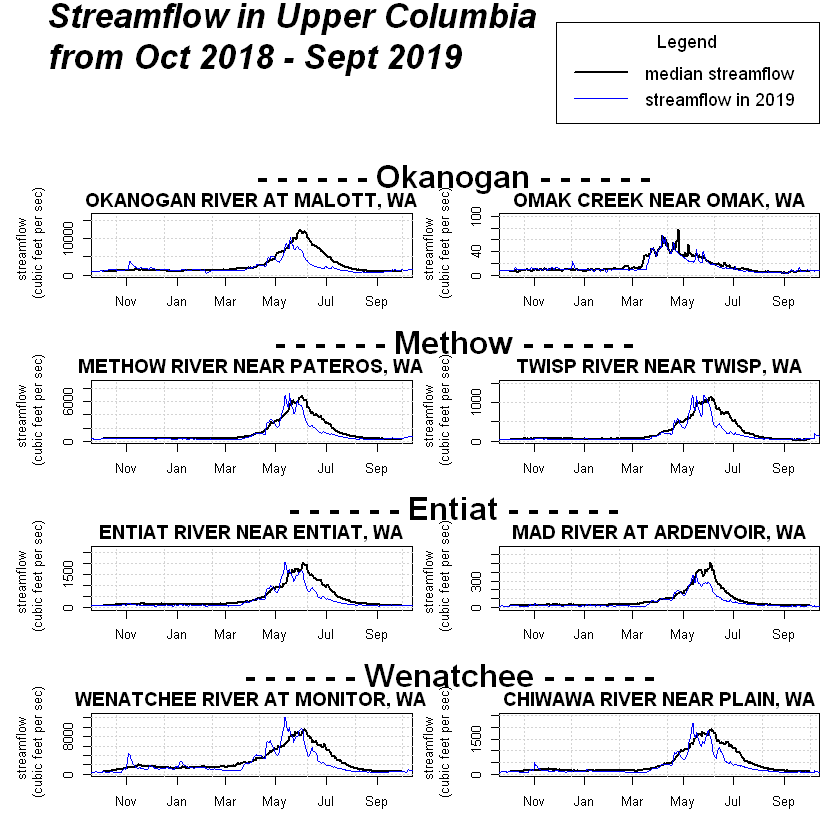

In [322]:
# options(repr.plot.width=2, repr.plot.height=4)

par(mfrow=c(5, 2), oma=c(0.5, 0.8, 0, 0.8), mar=c(3.5, 5, 3, 0.5),  xpd=FALSE)

for(i in 1:nrow(USGS_sites)){

    
    # ------------------------------------------------------------
    #        put blank plot in Entiat (since only one)
    # ------------------------------------------------------------

    if( i == 1){
        plot.new()
        par(xpd=TRUE)
        plot.new()
        legend("bottomright", inset=c(0,-0.2), legend=c("median streamflow", paste("streamflow in", year_to_plot, sep=" ") ), 
        lty=c(1, 1), title="Legend", col=c("black","blue"), lwd=c(2.1, 1.4), seg.len = 3, cex=1.4)
        
    }
    par(xpd=FALSE)
    
    # ------------------------------------------------------------
    #          Prepare the Data
    # ------------------------------------------------------------
    print(i)
    print(USGS_sites$USGS_site_no[i])
    # ------------------------ generate the median snotel -------------------
    streamflow_data_x = as.numeric(as.character(all_USGS_data[[as.numeric(USGS_sites$USGS_site_no[i])]]$'discharge_ft3_sec' ))
    date_vector = all_USGS_data[[as.numeric(USGS_sites$USGS_site_no[i])]]$'datetime'
    date_vector = as.POSIXct(date_vector, format="%Y-%m-%d") #  convert to date time 
    
    # ------------------------ generate the median snotel -------------------
    median_streamflow_data_x = median_flow_function(streamflow_data_x, date_vector, year_to_plot)
    
    # ------------------------------------------------------------
    #         Plot the Data
    # ------------------------------------------------------------
    max_ylim = max(median_streamflow_data_x$metric, na.rm=T) 
    max_ylim = max_ylim + max_ylim*0.3
    
    #xlim_min = as.Date(paste('10-01-',year_to_plot-1, sep=""), format = '%m-%d-%Y')
    #xlim_max = as.Date(paste('09-30-',year_to_plot, sep=""), format = '%m-%d-%Y')

    plot(median_streamflow_data_x$day_of_hydro_year[order(median_streamflow_data_x$day_of_hydro_year)],
         median_streamflow_data_x$metric[order(median_streamflow_data_x$day_of_hydro_year)] , 
         type='l', col='black', lwd=2,
        xlab=' ',ylab='streamflow  \n (cubic feet per sec)', ylim=c(0, max_ylim), 
        xlim=c(min(median_streamflow_data_x$day_of_hydro_year) + 86400 * 2 , max(median_streamflow_data_x$day_of_hydro_year)  - 86400 * 2 ) )
    grid(lwd=1.5)
    lines(median_streamflow_data_x$day_of_hydro_year[order(median_streamflow_data_x$day_of_hydro_year)],
         median_streamflow_data_x$metric[order(median_streamflow_data_x$day_of_hydro_year)], col='black',lwd=2.2)
    
    mtext(USGS_sites$Site_name[i], side=3, line=0.3, font=2, cex=0.95)
    
    lines(date_vector, streamflow_data_x, lwd=1.4, col='blue', lty=1)

    # ------------------------------------------------------------
    #      Insert title
    # ------------------------------------------------------------
    
    if(i == 1){
        
        year_span = paste(year_to_plot-1,year_to_plot,sep=" - Sept ")
        mtext( paste("          Streamflow in Upper Columbia \n from Oct ",year_span, sep="") , side=3, line=9, cex=1.7, font=4)
        
    }
    
    # ------------------------------------------------------------
    #      Insert legend
    # ------------------------------------------------------------
    
    
    if(i ==2){
        
        #legend("topright", inset=c(0,-0.3), legend=c("median streamflowpack", paste("streamflowpack in", year_to_plot, sep=" ") ), 
        #       lty=c(1, 2), title="Legend", col=c("black","blue"), lwd=c(2, 2.5))
        
    }
    
    # ------------------------------------------------------------
    #      Add Watershed Name
    # ------------------------------------------------------------
    
    if(i == 1){
        # mtext('                                                 Okanogan', side=3, line=1.5, font=2, cex=1.6)
        mtext('                                              - - - - - - Okanogan - - - - - - ', side=3, line=1.5, font=2, cex=1.6)

    }else if(i == 3){
        #mtext('                                                 Methow', side=3, line=1.5, font=2, cex=1.6)
        mtext('                                              - - - - - - Methow - - - - - - ', side=3, line=1.5, font=2, cex=1.6)
    }else if(i == 5){
        #mtext('                                                 Entiat', side=3, line=1.5, font=2, cex=1.6)
        mtext('                                              - - - - - - Entiat - - - - - - ', side=3, line=1.5, font=2, cex=1.6)

    }else if(i == 7){
        #mtext('                                                 Wenatchee', side=3, line=1.5, font=2, cex=1.6)
        mtext('                                             - - - - - - Wenatchee - - - - - - ', side=3, line=1.5, font=2, cex=1.6)
    }
        
 
}





